<a href="https://colab.research.google.com/github/himanshu-iitg/nlp/blob/main/write_MLP_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github that will be used for training, to generate similar names
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-07-14 13:21:16--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-07-14 13:21:16 (6.94 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [3]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# if using GPU, then you can check GPU name using below command
# torch.cuda.get_device_name(0)

cpu


In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
vocab  = sorted(list(set(''.join(words))))

vocab_size = len(vocab) + 1
print(vocab_size)


stoi = {s: i + 1 for i, s in enumerate(vocab)}
itos = {i+1: s for i, s in enumerate(vocab)}
stoi['.'] = 0
itos[0] = '.'

encoder = lambda x: [stoi[s] for s in x]
decoder = lambda x: [itos[i] for i in x]

27


In [7]:
import random
random.seed(42)
random.shuffle(words)
tr = int(0.8*len(words))
v = int(0.9*len(words))

In [8]:
# fix seed to compare results properly
g = torch.Generator().manual_seed(2147483647)

# set some hyperparmeters
batch_size = 32
n_embd = 10
n_hid = 200
lr = 1e-1
n = 3
max_iteration = 200000

In [9]:
%%time
# create a train test and validation data
def build_dataset(words):
  X = []
  Y = []

  for word in words:
    context = [0]*n
    for w in word + '.':
      ix = stoi[w]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

Xtr, Ytr = build_dataset(words[:tr])
Xv, Yv = build_dataset(words[tr:v])
Xt, Yt = build_dataset(words[v:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
CPU times: user 1.05 s, sys: 20.4 ms, total: 1.07 s
Wall time: 1.33 s


In [10]:
# create a very basic ML architecture using tensors

# create embedding vector for character level encoding
emb= torch.randn(vocab_size, n_embd, generator=g)

# Use tensors to calculate weights
W1 = torch.randn(n_embd*n, n_hid, generator=g)
b1 = torch.randn(n_hid, generator=g)

W2 = torch.randn(n_hid, vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [emb, W1, b1, W2, b2]

In [11]:
# number of parameters that are being trained
sum([p.numel() for p in parameters])

11897

In [12]:
for p in parameters:
  p.requires_grad = True

In [13]:
%%time
stepi = []
losso = []

for iter in range(max_iteration):
  ix = torch.randint(Xtr.shape[0], (batch_size,))
  xset = Xtr[ix]
  yset = Ytr[ix]

  # forward pass
  x2 = torch.tanh(emb[xset].view(xset.shape[0], -1)@W1 + b1)
  logit = x2@W2 + b2

  loss = F.cross_entropy(logit, yset)
  if iter % 10000==0 or iter==0:
    print(f'train loss = {loss:.4f}')

  stepi.append(iter)
  losso.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  if iter > 100000: # decay lr after some iterations to search in the local neighbourhood only now
    lr = 1e-2
  for p in parameters:
    p.data += -lr*p.grad

  # print(probs.shape, probs[0])
  # if iter> 100:
  #   break

train loss = 26.9689
train loss = 2.2371
train loss = 1.9779
train loss = 2.5493
train loss = 2.4585
train loss = 2.5641
train loss = 2.2016
train loss = 2.5700
train loss = 2.4574
train loss = 2.4401
train loss = 2.0211
train loss = 2.0097
train loss = 2.5567
train loss = 2.1448
train loss = 2.0647
train loss = 2.4211
train loss = 1.8134
train loss = 2.0841
train loss = 2.3507
train loss = 2.3324
CPU times: user 2min 4s, sys: 304 ms, total: 2min 4s
Wall time: 2min 10s


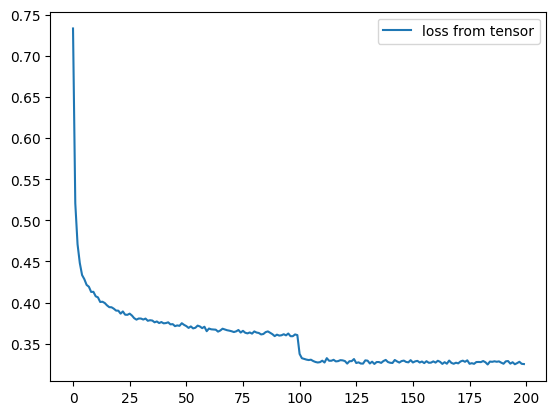

In [130]:
# plt.plot(lossi)
loss_plot = plt.figure()
loss_plot.gca().plot(torch.tensor(losso).view(-1, 1000).mean(1))
loss_plot.gca().legend(['loss from tensor'])
loss_plot;

In [15]:
def get_score(x, y):
  xemb = emb[x]
  h = torch.tanh(xemb.view(x.shape[0], -1)@W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  return loss

# final training score
print('train', get_score(Xtr, Ytr))
print('validation', get_score(Xv, Yv))
print('test', get_score(Xt, Yt))

train tensor(2.1362, grad_fn=<NllLossBackward0>)
validation tensor(2.1703, grad_fn=<NllLossBackward0>)
test tensor(2.1725, grad_fn=<NllLossBackward0>)


In [117]:
# instead of importing let us just write our own functions for cases we may need to create a new function
# create basic pytorch functions to use for model
class Embedding(nn.Module):
  def __init__(self, domain_size, embedding_size):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(domain_size, embedding_size))

  def __call__(self, x):
    self.out = self.weight[x]
    return self.out

  def parameters(self):
    return [self.weight]


class Tanh(nn.Module):
  def __call__(self, x):
    if self.training:
      self.out = torch.tanh(x)
      self.out.retain_grad()
      return self.out
    else:
      return torch.tanh(x)

  def parameters(self):
    return []

class Flatten(nn.Module):
  def __call__(self, x):
    fl = x.view(x.shape[0], -1)
    self.out = fl
    return fl

  def parameters(self):
    return []

class Linear(nn.Module):
  def __init__(self, fan_in, fan_out, bias=True):
    super().__init__()
    self.W = nn.Parameter(torch.randn(fan_in, fan_out, generator=g)/fan_in**0.5)
    # self.b = torch.randn(fan_out, generator=g)/fan_in**0.5 if bias else None
    self.b = nn.Parameter(torch.zeros(fan_out, generator=g)) if bias else None

  def __call__(self, x):
    self.out = x@self.W
    if self.b is not None:
      self.out += self.b
    return self.out

  def parameters(self):
    return [self.W] + [[] if self.b is None else self.b]

class Norm1D(nn.Module):
  def __init__(self, dim, eps=1e-5, momentum=0.1, training=True, norm_dim=0):
    # super(Norm1D, self).__init__()
    super().__init__()
    self.norm_dim = norm_dim
    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(dim))
    self.beta = nn.Parameter(torch.zeros(dim))
    self.momentum = momentum
    self.training = training

    self.run_mean = torch.zeros(dim, device=device)
    self.run_var = torch.ones(dim, device=device)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(self.norm_dim, keepdims=True)
      xvar = x.var(self.norm_dim, keepdims=True)
    else:
      xmean = self.run_mean
      xvar = self.run_var

    xhat = (x - xmean)/torch.sqrt(xvar+self.eps)
    if self.training:
      with torch.no_grad():
        self.run_mean = (1-self.momentum)*self.run_mean + self.momentum*xmean
        self.run_var = (1-self.momentum)*self.run_var + self.momentum*xvar

    self.out = self.gamma*xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class BatchNorm1d(Norm1D):
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    super().__init__(dim, eps, momentum)


class LayerNorm1d(Norm1D):
  def __init__(self):
    super().__init__(norm_dim=1, training=False)

In [124]:
# convert above code to MLP using functions defined above
new_n_hid = int(n_hid/4)

model = nn.Sequential(Embedding(vocab_size, n_embd), Flatten(),
                       Linear(n_embd*n, new_n_hid, bias=False), BatchNorm1d(new_n_hid), Tanh(),
                       Linear(new_n_hid, new_n_hid, bias=False), BatchNorm1d(new_n_hid), Tanh(),
                       Linear(new_n_hid, new_n_hid, bias=False), BatchNorm1d(new_n_hid), Tanh(),
                       Linear(new_n_hid, new_n_hid, bias=False), BatchNorm1d(new_n_hid), Tanh(),
                       Linear(new_n_hid, vocab_size, bias=False), BatchNorm1d(vocab_size))

model = model.to(device)

for p in model.parameters():
  p.requires_grad=True

parameters = list(model.parameters())

with torch.no_grad():
  model[-1].gamma *= 0.1


In [125]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)
# [p for p in model.parameters]

+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |    270     |
|   2.W    |    1500    |
| 3.gamma  |     50     |
|  3.beta  |     50     |
|   5.W    |    2500    |
| 6.gamma  |     50     |
|  6.beta  |     50     |
|   8.W    |    2500    |
| 9.gamma  |     50     |
|  9.beta  |     50     |
|   11.W   |    2500    |
| 12.gamma |     50     |
| 12.beta  |     50     |
|   14.W   |    1350    |
| 15.gamma |     27     |
| 15.beta  |     27     |
+----------+------------+
Total Trainable Params: 11074


11074

In [126]:
lossi = []
vallossi = []
ud = []

In [127]:
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-3)

In [128]:
def get_model_train_key_value(model):
  return model[0].training

def set_model_train_keys(model, to=True):
  for m in model:
    m.training = to

def get_new_score(x, y):
  train_value = get_model_train_key_value(model)
  set_model_train_keys(model, to=False)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  set_model_train_keys(model, to=train_value)
  return loss

In [129]:
%%time
for iter in range(int(max_iteration)):
  ix = torch.randint(Xtr.shape[0], (batch_size,))
  # print(x1.shape)

  # forward pass
  logit = model(Xtr[ix])
  loss = F.cross_entropy(logit, Ytr[ix])
  lossi.append(loss.log10().item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  optimizer.step()

  if iter % 10000==0:
    print(f'train loss = {loss:.4f}')
  if iter % 1000==0:
    vallossi.append(get_new_score(Xv, Yv).log10().item())
    with torch.no_grad():
      # print(model[4].out.grad.shape)
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if iter > 100000:
  #   lr = 1e-2
  # for p in parameters:
  #   p.data += -lr*p.grad

train loss = 3.2914
train loss = 2.4197
train loss = 2.1762
train loss = 2.0779
train loss = 1.7880
train loss = 2.4929
train loss = 2.0484
train loss = 2.2717
train loss = 1.9486
train loss = 1.9199
train loss = 1.9421
train loss = 2.0765
train loss = 2.0409
train loss = 2.0228
train loss = 2.2049
train loss = 2.4248
train loss = 2.0966
train loss = 1.7286
train loss = 2.4727
train loss = 2.1335
CPU times: user 13min 10s, sys: 600 ms, total: 13min 10s
Wall time: 13min 13s


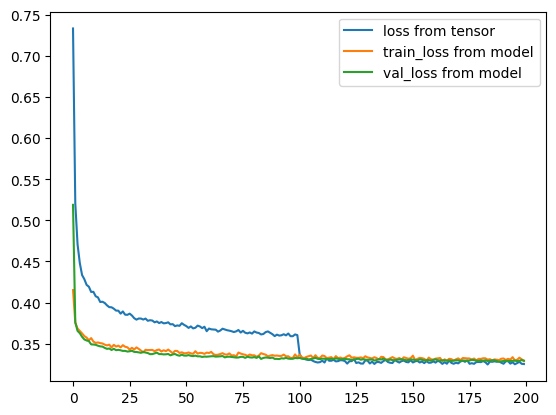

In [131]:
# plot all three loss values together
loss_plot.gca().plot(torch.tensor(lossi).view(-1, 1000).mean(1))
loss_plot.gca().plot(torch.tensor(vallossi))
loss_plot.gca().legend(['loss from tensor', 'train_loss from model', 'val_loss from model'])
loss_plot

In [132]:
# put layers into eval mode (needed for batchnorm especially)
set_model_train_keys(model, to=False)

In [133]:
# running these cells will do forward pass on tanh layers, causing gradiant values to get zero.
# this happens because value of out is overwritten in the forward pass where no back prop has happened, hence grad sets to None again
print('train score', get_new_score(Xtr, Ytr))
print('validation score', get_new_score(Xv, Yv))
print('test score', get_new_score(Xt, Yt))

train score tensor(2.0943, grad_fn=<NllLossBackward0>)
validation score tensor(2.1336, grad_fn=<NllLossBackward0>)
test score tensor(2.1301, grad_fn=<NllLossBackward0>)


layer 4 torch.Size([32, 50])
layer 4 (      Tanh): mean -0.000000, std 4.220462e-03
layer 7 torch.Size([32, 50])
layer 7 (      Tanh): mean -0.000000, std 3.942078e-03
layer 10 torch.Size([32, 50])
layer 10 (      Tanh): mean +0.000000, std 3.942415e-03
layer 13 torch.Size([32, 50])
layer 13 (      Tanh): mean -0.000000, std 5.656618e-03


Text(0.5, 1.0, 'gradient distribution')

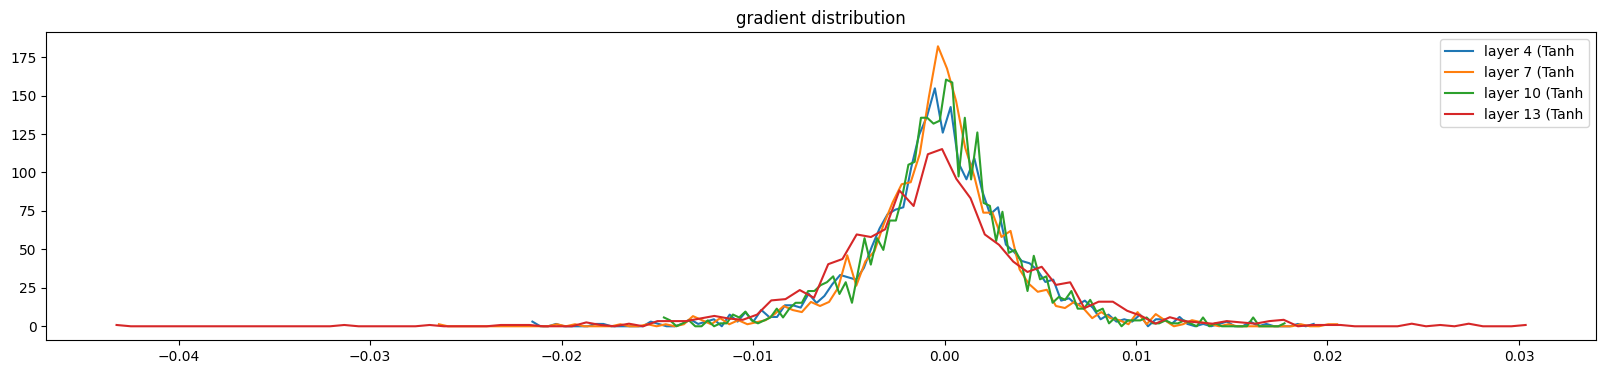

In [134]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    print('layer', i, layer.out.shape)
    t = layer.out.grad.to('cpu')
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

layer 4 (      Tanh): mean -0.03, std 0.75, saturated: 25.56%
layer 7 (      Tanh): mean +0.01, std 0.79, saturated: 30.38%
layer 10 (      Tanh): mean +0.00, std 0.84, saturated: 35.38%
layer 13 (      Tanh): mean +0.08, std 0.84, saturated: 37.50%


Text(0.5, 1.0, 'activation distribution')

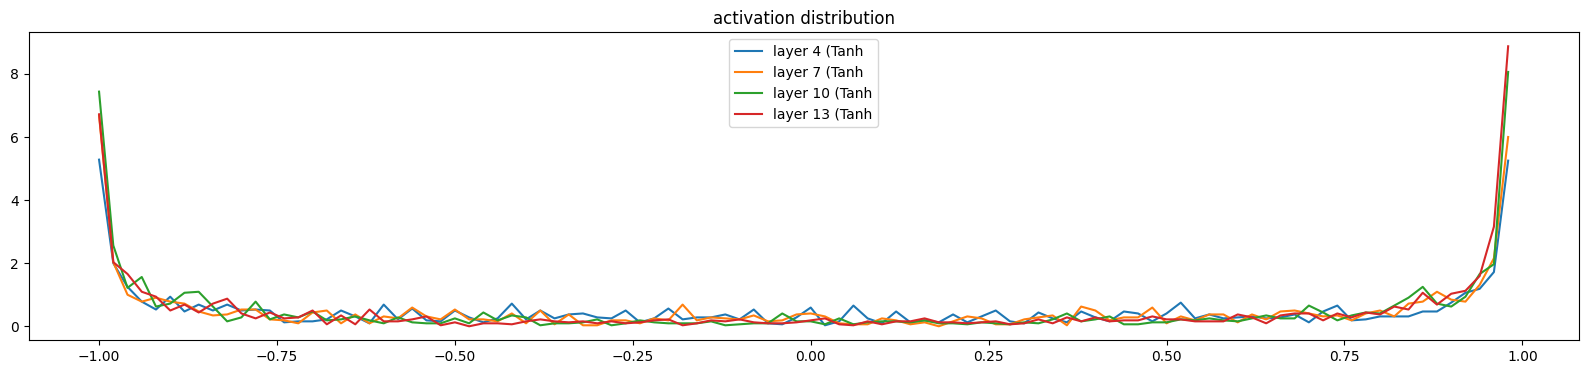

In [135]:
# the below plot indicates the learning in each activation layer
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.to('cpu')
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 7.421799e-03 | grad:data ratio 4.072465e-03
weight   (30, 50) | mean +0.000160 | std 2.996610e-03 | grad:data ratio 2.206992e-03
weight   (50, 50) | mean -0.000003 | std 1.740311e-03 | grad:data ratio 1.287421e-03
weight   (50, 50) | mean -0.000030 | std 1.655228e-03 | grad:data ratio 1.221957e-03
weight   (50, 50) | mean -0.000004 | std 1.555159e-03 | grad:data ratio 1.144082e-03
weight   (50, 27) | mean -0.000035 | std 2.813292e-03 | grad:data ratio 1.891248e-03


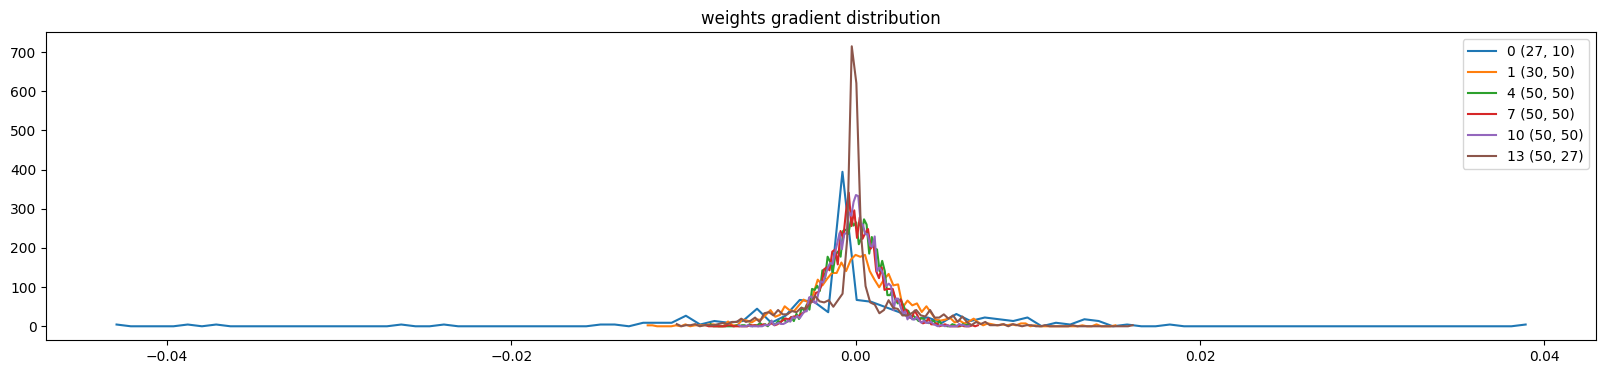

In [136]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad.to('cpu')
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

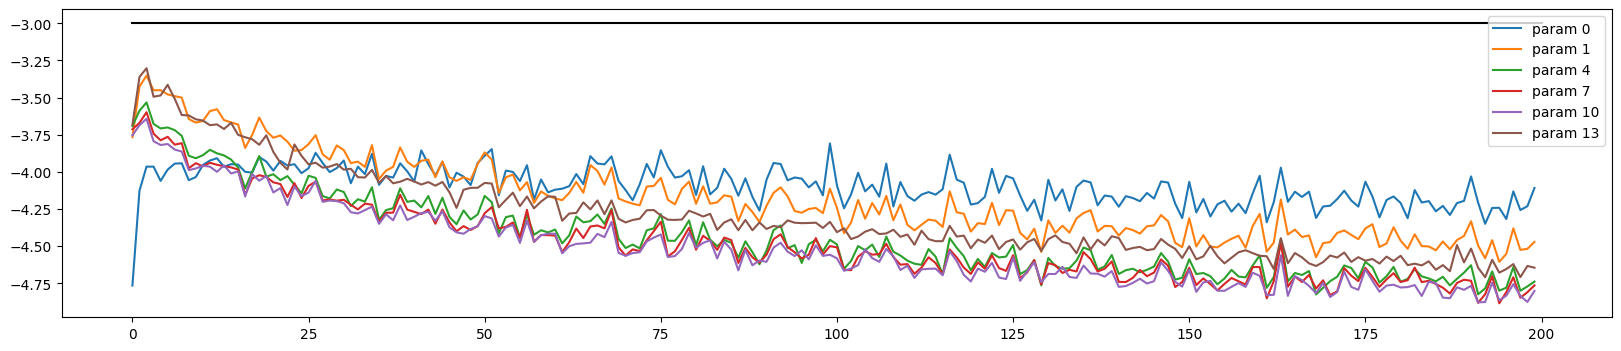

In [137]:
# this plot shows that lr can still
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

torch.Size([27, 3])


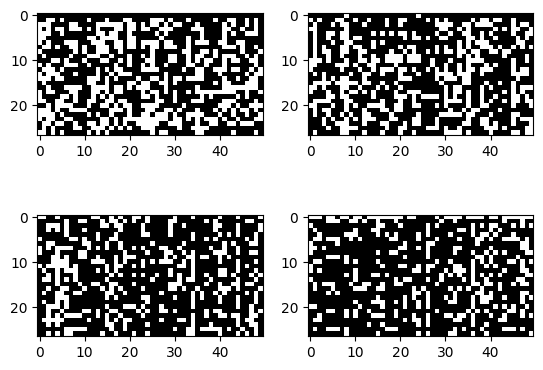

In [138]:
# this plot helps visualize what neurons are getting activated if word present in vocabulary
fig, axes = plt.subplots(2, 2)
out = []
a  = torch.concat([torch.ones(1, n).long()*r for r in range(vocab_size)])
print(a.shape)
for l in model:
  a = l(a)
  if isinstance(l, Tanh):
    out.append(a)

axes[0, 0].imshow(out[0].abs().detach() > 0.97, cmap='gray')
axes[0, 1].imshow(out[1].abs().detach() > 0.97, cmap='gray')
axes[1, 0].imshow(out[2].abs().detach() > 0.97, cmap='gray')
axes[1, 1].imshow(out[3].abs().detach() > 0.97, cmap='gray')

In [139]:
# generate outputs from both models

for _ in range(20):
  word = []
  context = [0]*n
  while True:
    logit = model(torch.tensor([context]))
    probs = F.softmax(logit, dim=1)

    ix = torch.multinomial(probs, num_samples=1).item()
    word.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break


  print('output from MLP model = ', '\t', ''.join(itos[ix] for ix in word))

output from MLP model =  	 bis.
output from MLP model =  	 ella.
output from MLP model =  	 lylin.
output from MLP model =  	 avina.
output from MLP model =  	 norie.
output from MLP model =  	 sth.
output from MLP model =  	 baiko.
output from MLP model =  	 tin.
output from MLP model =  	 kaiyah.
output from MLP model =  	 nix.
output from MLP model =  	 arwat.
output from MLP model =  	 samey.
output from MLP model =  	 ashiel.
output from MLP model =  	 demilanihey.
output from MLP model =  	 aquannah.
output from MLP model =  	 jin.
output from MLP model =  	 rah.
output from MLP model =  	 jozelin.
output from MLP model =  	 jaxlyne.
output from MLP model =  	 vic.


In [140]:
for _ in range(20):
  word = []
  context = [0]*n
  while True:
    x = torch.tensor([context])
    xemb = emb[x]
    h = torch.tanh(xemb.view(x.shape[0], -1)@W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1).item()
    word.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break

  print('output from tensor model = ', '\t', ''.join(itos[ix] for ix in word))

output from tensor model =  	 saimerin.
output from tensor model =  	 jurie.
output from tensor model =  	 clano.
output from tensor model =  	 ivia.
output from tensor model =  	 lediavet.
output from tensor model =  	 taan.
output from tensor model =  	 mika.
output from tensor model =  	 licarsheina.
output from tensor model =  	 deanalyna.
output from tensor model =  	 diiah.
output from tensor model =  	 tariela.
output from tensor model =  	 riga.
output from tensor model =  	 keeye.
output from tensor model =  	 tey.
output from tensor model =  	 jezer.
output from tensor model =  	 dani.
output from tensor model =  	 kaamar.
output from tensor model =  	 praia.
output from tensor model =  	 yaseler.
output from tensor model =  	 aladinitommonea.
